<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/dev/OM_Segmentation_valeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuration**

---



In [1]:
!pip install pyspark
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=841d79afb389fc3254976e7fce04753148a66e32f163830ea3c09bc3b62ed6f2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
path='/content/drive/MyDrive/Colab/Segmentation/0datasets'

import pyspark
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.clustering import *
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
spark

Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


In [169]:
#!git clone https://github.com/asish012/dataanalytics.git

# **DATA PREPARATION**

## **EDA**

---



In [3]:
def printdf(df):
    return df.toPandas()

In [4]:
om_transactions=spark.read.csv(f'{path}/trusted_om.base_transaction_om.csv', header=True)
new_column_names = [col_name.replace("base_transaction_om.", "") for col_name in om_transactions.columns]
om_transactions= om_transactions.toDF(*new_column_names)
om_transactions.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)



In [6]:
printdf(om_transactions)

,msisdn,destinataire,channel,date,description,fees,montant,operation,status,statuscode,titre,transactionid,typetransaction,ingest_date,year,month,day
0,1343744,9c96dd2d75bcc6865734fdd27ce99d01af8980c0d4d7d1...,USSD,2022-01-01 19:57:00,NULL,60.0,7500.0,Transfert,TS,200,NULL,ef697756de95134c1f7be45b905f972ac2e71074ec543d...,TRANSFERT,2023-04-13 18:42:07.504,2022,01,20220101
1,1343771,7da8da24cec7058794ef89c45497a438917ea3d02b3493...,USSD,2022-01-01 11:19:54,NULL,140.0,17500.0,Transfert,TS,200,NULL,666a152c786964f1bc9df0d05570ceb5523914c8ff76fb...,TRANSFERT,2023-04-13 18:42:07.504,2022,01,20220101
2,1343815,acc5869c735bc9f6f0c4fe7d46f741cb4901606544fab7...,USSD,2022-01-01 17:14:31,NULL,0.0,7000.0,CASHOUT,éffectué,TS,Retrait d'argent,d39598f1108a788fc2ed1d64c68914ce1c94032d4fa70e...,CASHOUT_CONFIRM,2023-04-13 18:42:07.504,2022,01,20220101
3,1343842,2c64d62d82054b09e641398ca516eb2e41ce8a73e9689c...,USSD,2022-01-01 11:52:37,NULL,16.0,2000.0,Transfert,TS,200,NULL,1e985054fa6e8f7f897ff1d27e3b0ef0af4c533905affe...,TRANSFERT,2023-04-13 18:42:07.504,2022,01,20220101
4,1343898,f891e11d32b9febc51b5e977bcc2c96aafdda725f3650a...,USSD,2022-01-01 15:56:41,NULL,40.0,5000.0,Transfert,TS,200,NULL,0bb21f1cef2245fb4639f10ae839df305435901379c585...,TRANSFERT,2023-04-13 18:42:07.504,2022,01,20220101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2116391,11d7ccbbd154db689e84d3cf973329826933ac0c5ef1c8...,mobile,2022-01-02 21:01:18.33,Achat Pass effectué,0.0,1000.0,Achat Pass,effectué,TS,Pass Internet,c87ffc0845018e8a10c26eaad01ef051fff9f89ebfa116...,achat_pass_data,2023-04-13 18:42:59.796,2022,01,20220102
99996,2116391,af4d3a11fdd4ffab0ec48be5117f6cb4f85155c1f6c3c3...,mobile,2022-01-02 19:49:37.529,Achat Illimix effectué,0.0,500.0,Achat Illimix,effectué,TS,Pass Illimix,ed839cb711c00c77543d10c72846a25ef4980fd2700bc2...,achat_pass_illimix,2023-04-13 18:42:59.796,2022,01,20220102
99997,2116440,25cca2b9c8025642e9a39f417d1b839130f628cd659fed...,USSD,2022-01-02 12:51:57,NULL,160.0,20000.0,Transfert,TS,200,NULL,f6a6781f1f539231d433023c3d51fc5946437dfc8610ad...,TRANSFERT,2023-04-13 18:42:59.796,2022,01,20220102
99998,2116503,3513d5530cd9b0b5d743cfbbeefb0b0a1d56323ce58356...,USSD,2022-01-02 18:46:18,NULL,24.0,3000.0,Transfert,TS,200,NULL,0a81ee61d5cbc0b11242165120d6d010279646514a12e6...,TRANSFERT,2023-04-13 18:42:59.796,2022,01,20220102


In [7]:
om_transactions.select("channel").distinct().show()
om_transactions.select("typetransaction").distinct().show()
om_transactions.select("day").distinct().show()

+-------------+
|      channel|
+-------------+
|       mobile|
|         USSD|
|DISTRI_MOBILE|
+-------------+

+-------------------+
|    typetransaction|
+-------------------+
|            CASHOUT|
|   paiement_facture|
|    achat_pass_data|
|  PAIEMENT_MARCHAND|
|    paiement_rapido|
|             CASHIN|
|                IRT|
|transfert_avec_code|
|    CASHOUT_CONFIRM|
|        CASHOUT_TAC|
|                C2C|
|       VENTE_CREDIT|
|        CASHINOTHER|
|transfert_sans_code|
| achat_pass_illimix|
|  paiement_marchand|
|   paiement_woyofal|
|          TRANSFERT|
|       achat_credit|
|       CASHIN_OTHER|
+-------------------+
only showing top 20 rows

+--------+
|     day|
+--------+
|20220101|
|20220102|
+--------+



In [8]:
om_transactions.describe().show()
print(f'Le nombre de colonnes: {len(om_transactions.columns)}')

+-------+-----------------+--------------------+-------------+--------------------+--------------------+------------------+------------------+-------------+--------+----------+-------+--------------------+-------------------+--------------------+--------------------+------+------------------+
|summary|           msisdn|        destinataire|      channel|                date|         description|              fees|           montant|    operation|  status|statuscode|  titre|       transactionid|    typetransaction|         ingest_date|                year| month|               day|
+-------+-----------------+--------------------+-------------+--------------------+--------------------+------------------+------------------+-------------+--------+----------+-------+--------------------+-------------------+--------------------+--------------------+------+------------------+
|  count|           100000|              100000|       100000|              100000|              100000|            10

In [9]:
# Initialize a list to store columns with all rows as NA
na_columns = []
# Check each column for all rows as NA
for column_name in om_transactions.columns:
    if om_transactions.filter(col(column_name).isNotNull()).count() == 0:
        na_columns.append(column_name)

# Print the columns with all rows as NA
print("Columns with all rows as NA:", na_columns)

Columns with all rows as NA: []


## **Data Preprocessing**

---



In [10]:
selected_columns = ["msisdn", "montant", "day"]
df = om_transactions.select(selected_columns).withColumnRenamed("msisdn", "Numero")
df.show()

+-------+-------+--------+
| Numero|montant|     day|
+-------+-------+--------+
|1343744| 7500.0|20220101|
|1343771|17500.0|20220101|
|1343815| 7000.0|20220101|
|1343842| 2000.0|20220101|
|1343898| 5000.0|20220101|
|1343940|15000.0|20220101|
|1343998|10000.0|20220101|
|1343998|10000.0|20220101|
|1344008| 5000.0|20220101|
|1344090|  500.0|20220101|
|1344099| 2000.0|20220101|
|1344200| 5000.0|20220101|
|1344288| 3050.0|20220101|
|1344293|  500.0|20220101|
|1344382| 5000.0|20220101|
|1344382| 4000.0|20220101|
|1344649| 1300.0|20220101|
|1344692| 1000.0|20220101|
|1344692| 1000.0|20220101|
|1344692| 2000.0|20220101|
+-------+-------+--------+
only showing top 20 rows



In [11]:
## Convert the date string to the desired format
# Assuming your DataFrame is named 'df' and the column is named 'day'
df = df.withColumn("date", to_date(df["day"], "yyyyMMdd")).drop("day")
# df= df.withColumn("day", date_format(to_timestamp(col("day"), "dd/MM/yyyy HH:mm:ss"), "yyyy-MM-dd HH:mm:ss"))
# df = df.withColumn("day", to_timestamp(col("day"), "yyyy-MM-dd HH:mm:ss"))

df.printSchema()
df.show()


root
 |-- Numero: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- date: date (nullable = true)

+-------+-------+----------+
| Numero|montant|      date|
+-------+-------+----------+
|1343744| 7500.0|2022-01-01|
|1343771|17500.0|2022-01-01|
|1343815| 7000.0|2022-01-01|
|1343842| 2000.0|2022-01-01|
|1343898| 5000.0|2022-01-01|
|1343940|15000.0|2022-01-01|
|1343998|10000.0|2022-01-01|
|1343998|10000.0|2022-01-01|
|1344008| 5000.0|2022-01-01|
|1344090|  500.0|2022-01-01|
|1344099| 2000.0|2022-01-01|
|1344200| 5000.0|2022-01-01|
|1344288| 3050.0|2022-01-01|
|1344293|  500.0|2022-01-01|
|1344382| 5000.0|2022-01-01|
|1344382| 4000.0|2022-01-01|
|1344649| 1300.0|2022-01-01|
|1344692| 1000.0|2022-01-01|
|1344692| 1000.0|2022-01-01|
|1344692| 2000.0|2022-01-01|
+-------+-------+----------+
only showing top 20 rows



In [12]:
max_date = df.agg(max("date")).collect()[0][0]
string_date=f'{max_date.year}/{max_date.month}/{max_date.day}'
latest_date = to_date(lit(string_date), 'yyyy/M/dd')
latest_date

Column<'to_date(2022/1/2, yyyy/M/dd)'>

# **MODELISATION**

---



## **Méthode RFM**

### Feature Engineering

In [31]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_recency = df.groupBy("Numero").agg(
    datediff(latest_date, max(col("date"))).alias("Recency")
)

# Calculate Frequency (number of transactions)
df_frequency = df.groupBy("Numero").agg(
    count("*").alias("Frequency")
)

# Calculate Monetary Value (total transaction amount)
df_monetary = df.groupBy("Numero").agg(
    sum("montant").alias("Monetary")
)

# Join the recency, frequency, and monetary DataFrames
rfm_df= df_recency.join(df_frequency, "Numero", "inner").join(df_monetary, "Numero", "inner")
#Save to csv
rfm_df.toPandas().to_csv('0datasets/om_rfm_dataset.csv', index=False)
# Show the RFM DataFrame
rfm_df.toPandas().head(10)

,Numero,Recency,Frequency,Monetary
0,1351030,1,1,6000.0
1,1383265,1,1,20000.0
2,1384880,0,2,30000.0
3,1390163,1,1,1000.0
4,1405229,0,3,14000.0
5,1405770,1,1,500.0
6,1446645,0,6,24150.0
7,1479088,0,2,126500.0
8,1503090,0,3,4000.0
9,1560328,1,1,21000.0


In [32]:
rfm_df.select("Recency").distinct().show()

+-------+
|Recency|
+-------+
|      1|
|      0|
+-------+



### Calcul des Scores

In [33]:
# Calculer les quantiles
quantiles = rfm_df.approxQuantile(["Recency", "Frequency", "Monetary"], [0.2, 0.4, 0.6, 0.8], 0.01)

# Définir des expressions conditionnelles pour attribuer les scores
rfm_df = (rfm_df
    .withColumn("R_Score",  when(col("Recency") <= quantiles[0][0], lit(5))
                            .when(col("Recency") <= quantiles[0][1], lit(4))
                            .when(col("Recency") <= quantiles[0][2], lit(3))
                            .when(col("Recency") <= quantiles[0][3], lit(2))
                            .otherwise(lit(1)))
    .withColumn("F_Score", when(col("Frequency") >= quantiles[1][3], lit(5))
                            .when(col("Frequency") >= quantiles[1][2], lit(4))
                            .when(col("Frequency") >= quantiles[1][1], lit(3))
                            .when(col("Frequency") >= quantiles[1][0], lit(2))
                            .otherwise(lit(1)))
    .withColumn("M_Score", when(col("Monetary") >= quantiles[2][3], lit(5))
                            .when(col("Monetary") >= quantiles[2][2], lit(4))
                            .when(col("Monetary") >= quantiles[2][1], lit(3))
                            .when(col("Monetary") >= quantiles[2][0], lit(2))
                            .otherwise(lit(1)))
     .withColumn("RFM_Score", concat(col("R_Score").cast(StringType()), col("F_Score").cast(StringType()), col("M_Score").cast(StringType())))
)

# Afficher le DataFrame résultant
printdf(rfm_df)

,Numero,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,1351030,1,1,6000.0,4,4,3,443
1,1383265,1,1,20000.0,4,4,4,444
2,1384880,0,2,30000.0,5,5,5,555
3,1390163,1,1,1000.0,4,4,1,441
4,1405229,0,3,14000.0,5,5,4,554
...,...,...,...,...,...,...,...,...
37406,2088162,0,1,2000.0,5,4,2,542
37407,2111536,0,1,500.0,5,4,1,541
37408,1571415,0,1,10000.0,5,4,4,544
37409,1928520,0,1,5000.0,5,4,3,543


### Profilage des segments

In [16]:
# segments2 = {
#    "En train de les perdre mais engagés": ["111", "112", "121", "131", "141", "151"],
#    "Sur le Point de Dormir": [
#         "331", "321", "312", "221", "213", "231", "241", "251"
#     ],
#     "Impossible de les perdre, mais en train de les perdre": [
#         "155", "154", "144", "214", "215", "115", "114", "113"
#     ],
# }

segments = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
     'Nouveau': ['512', '511', '422', '421', '412', '411', '311'],
}


# Utiliser une expression conditionnelle pour attribuer les segments
rfm_df =  (rfm_df
    .withColumn('Segment',
        when(col('RFM_Score').isin(segments['Champion']), lit('Champion'))
        .when(col('RFM_Score').isin(segments['Fidèle']), lit('Fidèle'))
        .when(col('RFM_Score').isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
        .when(col('RFM_Score').isin(segments['Nouveau']), lit('Nouveau'))
        .when(col('RFM_Score').isin(segments['Prometteur']), lit('Prometteur'))
        .when(col('RFM_Score').isin(segments['À surveiller']), lit('À surveiller'))
        # .when(col('RFM_Score').isin(segments['À réactiver']), lit('À réactiver'))
        .when(col('RFM_Score').isin(segments['À risque']), lit('À risque'))
        # .when(col('RFM_Score').isin(segments['A ne pas perdre']), lit('A ne pas perdre'))
        .when(col('RFM_Score').isin(segments['En sommeil']), lit('En sommeil'))
        .when(col('RFM_Score').isin(segments['Perdu']), lit('Perdu'))
        .otherwise(lit('Autre'))
    )
)


printdf(rfm_df)


,Numero,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,1351030,1,1,6000.0,4,4,3,443,À surveiller
1,1383265,1,1,20000.0,4,4,4,444,Fidèle
2,1384880,0,2,30000.0,5,5,5,555,Champion
3,1390163,1,1,1000.0,4,4,1,441,Fidèle potentiel
4,1405229,0,3,14000.0,5,5,4,554,Champion
...,...,...,...,...,...,...,...,...,...
37406,2088162,0,1,2000.0,5,4,2,542,Fidèle potentiel
37407,2111536,0,1,500.0,5,4,1,541,Fidèle potentiel
37408,1571415,0,1,10000.0,5,4,4,544,Champion
37409,1928520,0,1,5000.0,5,4,3,543,Fidèle


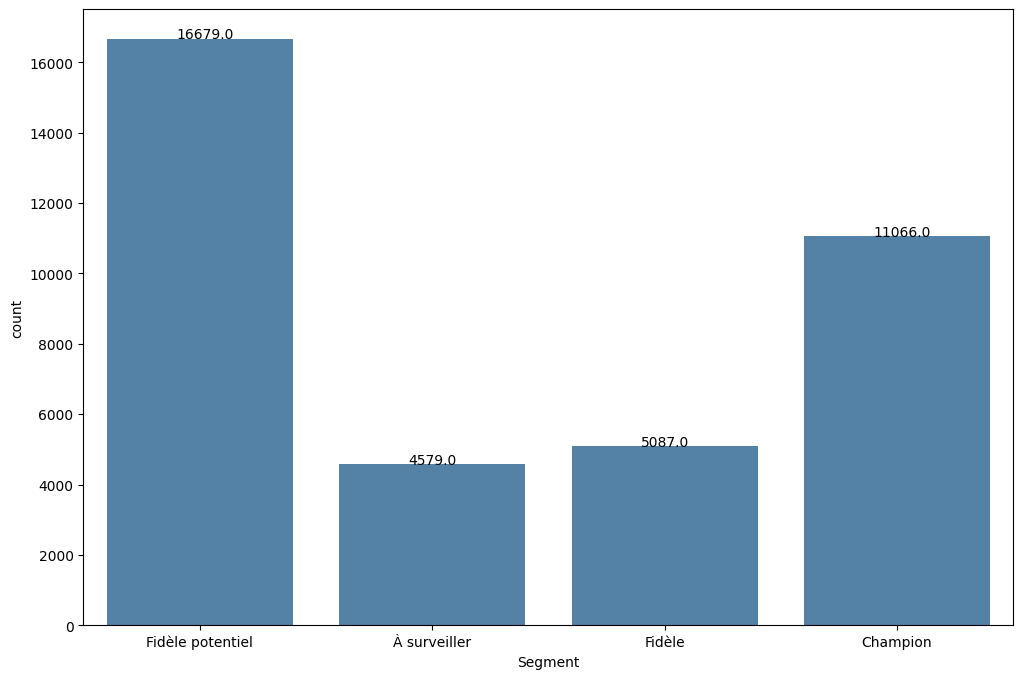

In [17]:
df_rfm_segment = rfm_df.toPandas().sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# sns.histplot(df_rfm_fidelite["Fidelite"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=df_rfm_segment, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [18]:
def customer_segment(num):
  return rfm_df.select("Numero","Segment").where(col("Numero")==num).collect()[0][1]

customer_segment(1571415)

'Champion'

## **Méthode K-Means**

---





### Feature engineering

In [ ]:
k_df=

### Nombre de clusters

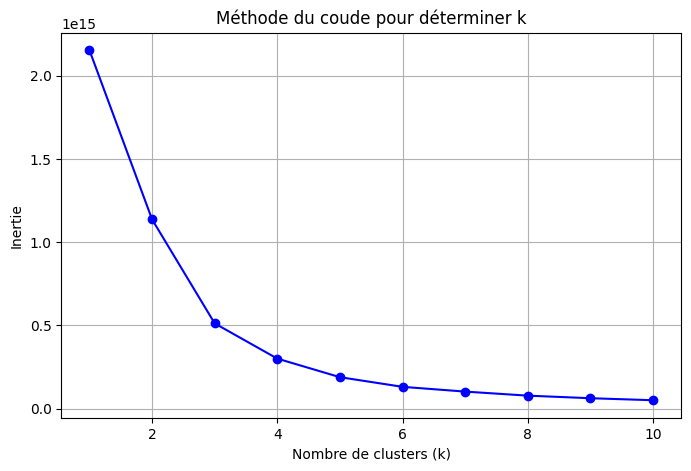

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Sélectionner les colonnes RFM pour l'analyse
rfm_pd=rfm.toPandas()
rfm_features = rfm_pd[['Recency', 'Frequency', 'Monetary']]

# Liste des valeurs de k à tester
k_values = range(1, 11)

# Liste pour stocker les valeurs d'inertie (somme des carrés des distances)
inertia_values = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia_values.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.grid(True)
plt.show()


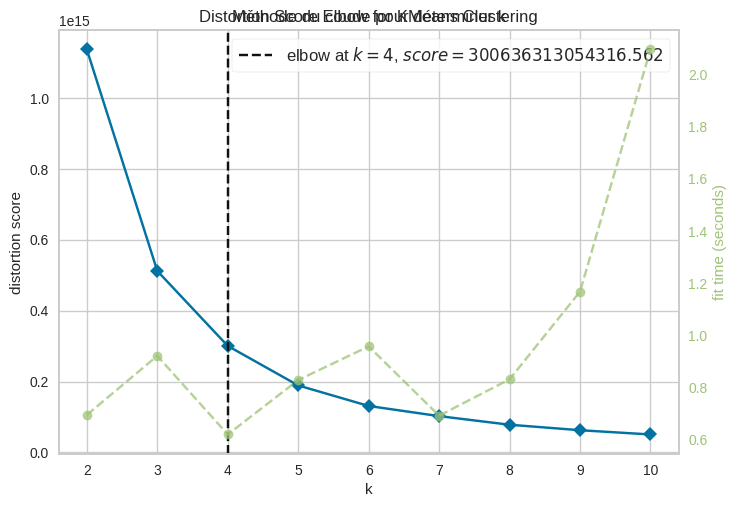

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Sélectionner les colonnes RFM pour l'analyse
rfm_pd=rfm.toPandas()
rfm_features = rfm_pd[['Recency', 'Frequency', 'Monetary']]

# Liste des valeurs de k à tester
k_values = range(1, 11)

# Liste pour stocker les valeurs d'inertie (somme des carrés des distances)
inertia_values = []

# Calculer l'inertie pour chaque valeur de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_features)
    inertia_values.append(kmeans.inertia_)

# k is range of number of clusters.
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(n_clusters=k_values, max_iter=300, random_state=42), k_values=(1,10), timings= True)
visualizer.fit(rfm_features)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.grid(True)
visualizer.show()

### Modèle

In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the features for K-Means clustering
X = rfm_pd[["Recency", "Frequency", "Monetary"]]

# Define the number of clusters
n_clusters = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
rfm_pd["Cluster"] = kmeans.fit_predict(X)
rfm_pd.head(15)

,Numero,Recency,Frequency,Monetary,Cluster
0,1351030,1,1,6000.0,0
1,1383265,1,1,20000.0,0
2,1384880,0,2,30000.0,0
3,1390163,1,1,1000.0,0
4,1405229,0,3,14000.0,0
5,1405770,1,1,500.0,0
6,1446645,0,6,24150.0,0
7,1479088,0,2,126500.0,0
8,1503090,0,3,4000.0,0
9,1560328,1,1,21000.0,0


### Visualisation des segments K-Means

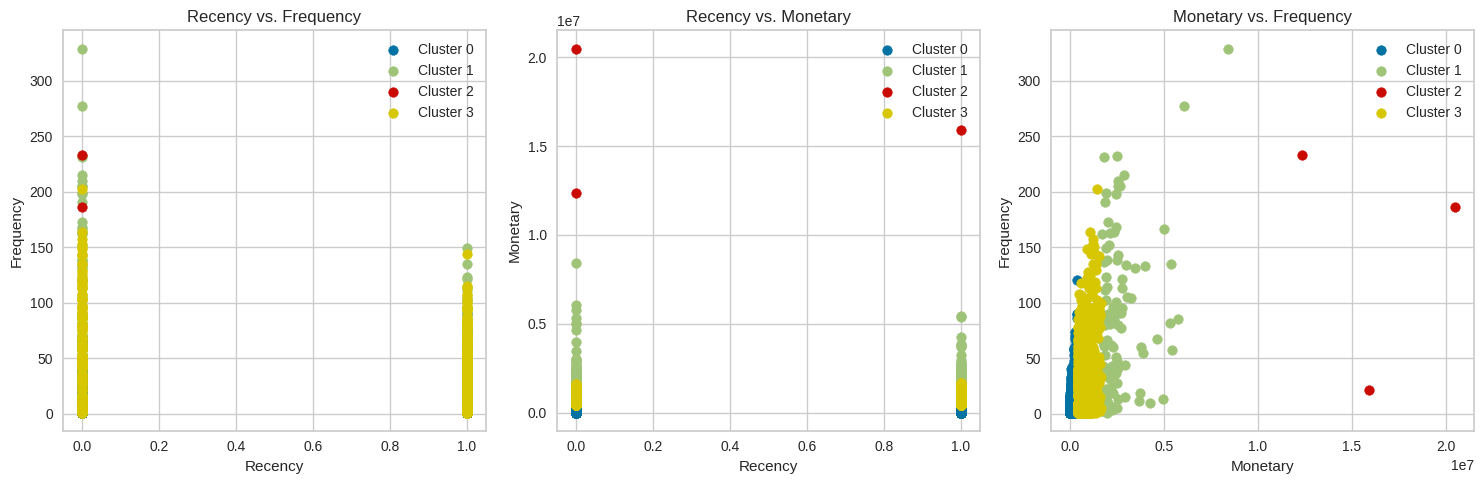

In [22]:
# Now rfm_df contains a new column "Cluster" with cluster labels
# You can access the cluster labels and further analyze the results

# Create a color map for the clusters
colors = ['b', 'g', 'r', 'y']  # You can add more colors if needed

# Create a figure with three subplots in one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Subplot 1
for cluster, color in zip(range(n_clusters), colors):
    axes[0].scatter(
        rfm_pd[rfm_pd["Cluster"] == cluster]["Recency"],
        rfm_pd[rfm_pd["Cluster"] == cluster]["Frequency"],
        c=color,
        label=f'Cluster {cluster}'
    )
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Recency vs. Frequency")
axes[0].legend()

# Subplot 2
for cluster, color in zip(range(n_clusters), colors):
    axes[1].scatter(
        rfm_pd[rfm_pd["Cluster"] == cluster]["Recency"],
        rfm_pd[rfm_pd["Cluster"] == cluster]["Monetary"],
        c=color,
        label=f'Cluster {cluster}'
    )
axes[1].set_xlabel("Recency")
axes[1].set_ylabel("Monetary")
axes[1].set_title("Recency vs. Monetary")
axes[1].legend()

# Subplot 3
for cluster, color in zip(range(n_clusters), colors):
    axes[2].scatter(
        rfm_pd[rfm_pd["Cluster"] == cluster]["Monetary"],
        rfm_pd[rfm_pd["Cluster"] == cluster]["Frequency"],
        c=color,
        label=f'Cluster {cluster}'
    )
axes[2].set_xlabel("Monetary")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Monetary vs. Frequency")
axes[2].legend()

# Adjust the layout
plt.tight_layout()

# Display the subplots
plt.show()


### Profilage des segments

In [23]:
rfm_k=spark.createDataFrame(rfm_pd)
rfm_k =  (rfm_k
    .withColumn('Segment',
        when(col('Cluster')==0, lit('Very High'))
        .when(col('Cluster')==1, lit('High'))
        .when(col('Cluster')==2, lit('Medium'))
         .when(col('Cluster')==3, lit('Low'))
        .otherwise(lit('Autre'))
    )
)

printdf(rfm_k.filter(col("Segment")=="Medium"))

,Numero,Recency,Frequency,Monetary,Cluster,Segment
0,1377467,0,186,20490500.0,2,Medium
1,2052563,0,233,12332535.0,2,Medium
2,1180420,1,21,15904500.0,2,Medium


## **CLTV**
<center>
<div class="alert alert-block alert-info">
<b>Quelle est la CLTV (valeur à vie du client - Customer LifeTime) ?</b> </div></center>

La valeur à vie du client (CLTV) est une prédiction du bénéfice net attribué à l'ensemble de la relation future avec un client. Il estime la valeur totale qu'une entreprise tirera d'une relation client, en tenant compte des revenus, des coûts et des modèles de comportement des clients sur une période de temps définie. CLTV aide les entreprises à comprendre la valeur de l'acquisition et de la fidélisation des clients, et à orienter les décisions d'investissement dans les initiatives de gestion de la relation client.


<center>
<div class="alert alert-block alert-info">
<b>À propos du processus de cette section</b> </div></center>

Je vais appliquerdeux modèles: BetaGeoFitter et GammaGammaFitter. Je vais utiliser le modèle BetaGeoFilter pour prédire la fréquence à laquelle le client achète. Je vais utiliser le modèle GammaGammaFilter pour prédire le profit qu'un client apportera. Et puis je vais analyser les données.

In [24]:
clt_df=rfm.toPandas()
clt_df.head()

,Numero,Recency,Frequency,Monetary
0,1351030,1,1,6000.0
1,1383265,1,1,20000.0
2,1384880,0,2,30000.0
3,1390163,1,1,1000.0
4,1405229,0,3,14000.0


### Calculating and subtracting outlier values from the data <a id = "4a"></a>
In this chapter, I am going to calculate and subtract outlier values from the data

At the code blocks below, I am going to calculate the outlier with outlier_thresholds and then subtract it with replace_with_threshold.

In [25]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

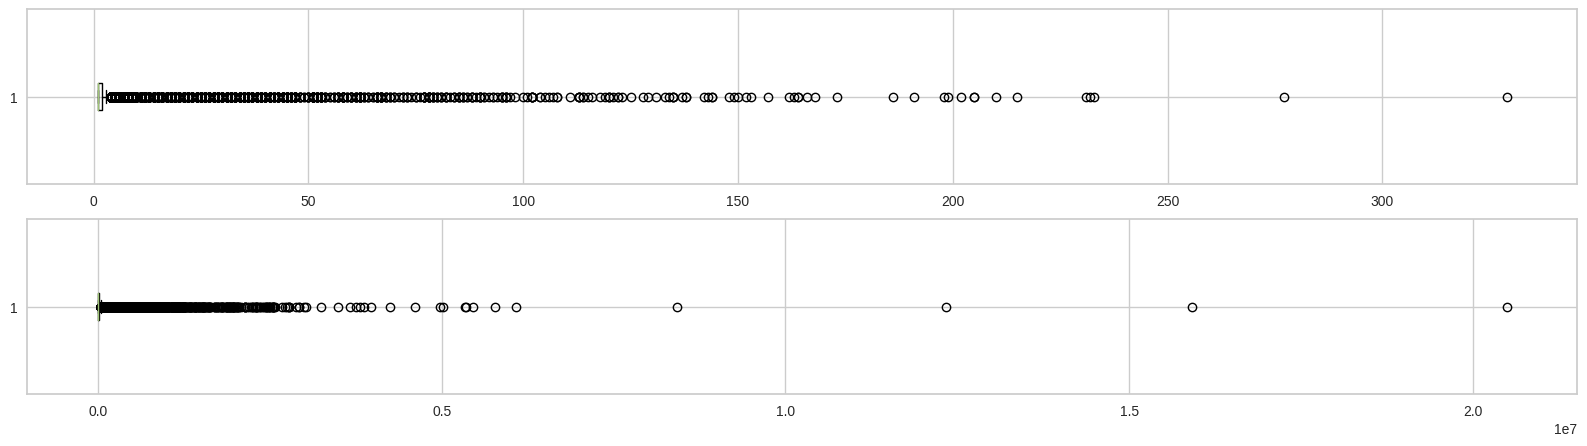

In [26]:
# I observe them before removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Frequency", "Monetary"]
for i in range(0,2):
    ax[i].boxplot(clt_df[col_list[i]], vert = 0)
plt.show()

In [27]:
# I apply the functions for remove the outlier.
replace_with_threshold(clt_df, "Frequency")
replace_with_threshold(clt_df, "Monetary")

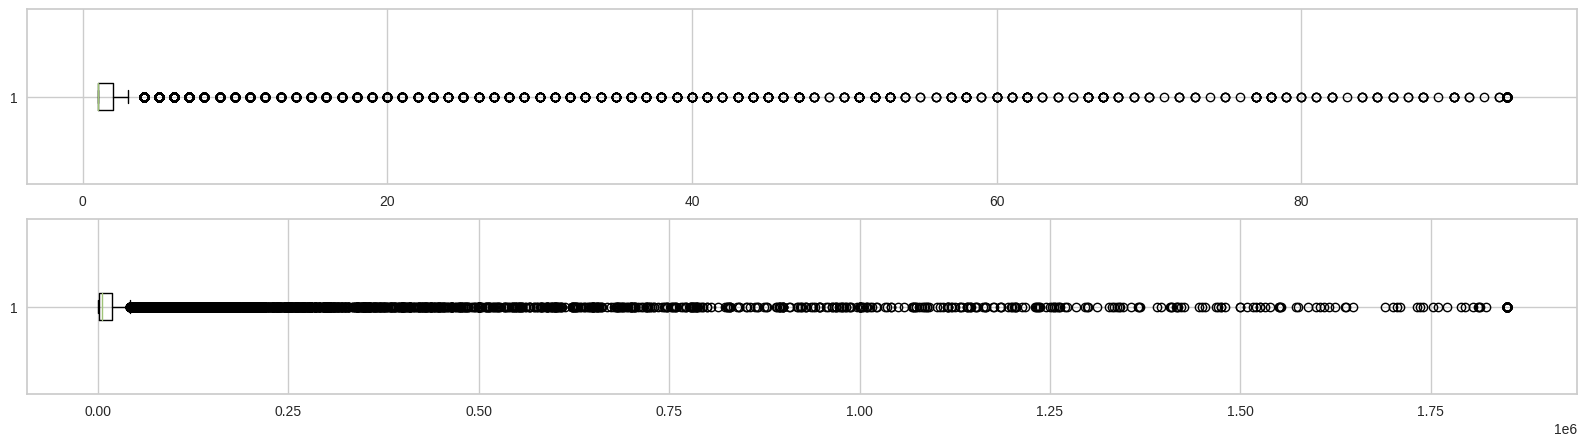

In [28]:
# I observe them after removing outliers.
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(clt_df[col_list[i]], vert = 0)
plt.show()

In [29]:
clt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37411 entries, 0 to 37410
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Numero     37411 non-null  object 
 1   Recency    37411 non-null  int32  
 2   Frequency  37411 non-null  float64
 3   Monetary   37411 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 1023.1+ KB


### BG-NBD <a id= "4c"></a>
In this section, I will apply the BetaGeoFitter model to the clt_df I created.

In [30]:
# Model
bgf = BetaGeoFitter(penalizer_coef = 0.001)

# fit with frequency, recency, and T values.
bgf.fit(clt_df["Frequency"],
       clt_df["Recency"],
       clt_df["Monetary"])

/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/autograd/tracer.py:48: RuntimeWarnin

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: nan
        x: [-5.696e+04 -8.989e+04 -1.070e+04 -4.699e+03]
      nit: 14
      jac: [       nan        nan        nan        nan]
 hess_inv: [[ 4.815e+02  7.574e+02  9.204e+01  3.851e+01]
            [ 7.574e+02  1.192e+03  1.451e+02  6.044e+01]
            [ 9.204e+01  1.451e+02  1.841e+01  7.518e+00]
            [ 3.851e+01  6.044e+01  7.518e+00  3.953e+00]]
     nfev: 134
     njev: 134


ConvergenceError: ignored

At the code block below, I calculate how often shop customers in one month with the BetaGeoFitter model.

In [ ]:
# Calculating one monthly values
bgf.predict(4,
           clt_df["Frequency"],
           clt_df["Recency"],
           clt_df["Monetary"]).sort_values(ascending = False).head(10)

In [ ]:
# Calculating three monthly values
bgf.predict(4*3,
           clt_df["Frequency"],
           clt_df["Recency"],
           clt_df["Monetary"]).sort_values(ascending = False).head(10)

In [ ]:
# Adding the three monthly values to the clt_df
clt_df["expected_purc_3_month"] = bgf.predict(4*3,
                                               clt_df["Frequency"],
                                               clt_df["Recency"],
                                               clt_df["Monetary"])

In [ ]:
clt_df.head()

In [ ]:
# Calculating six monthly values
bgf.predict(4*6,
           clt_df["Frequency"],
           clt_df["Recency"],
           clt_df["Monetary"]).sort_values(ascending = False).head(10)

In [ ]:
# Adding the six monthly values to the clt_df
clt_df["expected_purc_6_month"] = bgf.predict(4*6,
                                               clt_df["Frequency"],
                                               clt_df["Recency"],
                                               clt_df["Monetary"])

In [ ]:
clt_df.head()

### Gamma Gamma <a id="4d"></a>
In this section, I will apply the GammaGammaFitter model to the clt_df I created.

In [ ]:
# Model
ggf = GammaGammaFitter(penalizer_coef = 0.01)

# fitting with frequency adn monetary values
ggf.fit(clt_df["Frequency"], clt_df["Monetary"])

At the code block below, I calculate how much profit a customer will bring in with the gammagammafitter model.

In [ ]:
ggf.conditional_expected_average_profit(clt_df["Frequency"], clt_df["Monetary"]).sort_values(ascending = False).head(10)

In [ ]:
# Adding the prediction values to df_rfm.
clt_df["expected_average_profit"] = ggf.conditional_expected_average_profit(clt_df["Frequency"], clt_df["Monetary"])

In [ ]:
clt_df.head()

At the code block below, I calculate the cltv values of the customer.

In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                                  clt_df["Frequency"],
                                  clt_df["Recency"],
                                  clt_df["Monetary"],
                                  clt_df["Monetary"],
                                  time = 6, # six mounth
                                  freq = "W",
                                  discount_rate = 0.01)

In [ ]:
cltv.head(10)

In [ ]:
# Adding the cltv values to the clt_df.
clt_df["cltv"] = cltv

In [ ]:
clt_df.head()

### Segmentation <a id = "4e"></a>
In this chapter, I split the cltv values into segments.

In [ ]:
clt_df["segment"] = pd.qcut(clt_df["cltv"], 4, labels = ["D", "C", "B", "A"])

In [ ]:
clt_df.head()

### Review The CLTV DataFrame <a id="4f"></a>
In this chapter, I am going to review the clt_df.

In [ ]:
clt_df.head()

At the code below, I check count, mean, and sum value of segments on the other values.

In [ ]:
clt_df.groupby("segment").agg({"count", "mean", "sum"})

In [ ]:
clt_df.sort_values(by = "Recency", ascending = False).head()

In [ ]:
def check_cltv_best_and_worst(column):
    print(f"############ Top five - {column} ############")
    print(clt_df.sort_values(by = column, ascending = False).head())
    print(f"############ Bottom five - {column} ############")
    print(clt_df.sort_values(by = column, ascending = True).head())

In [ ]:
check_cltv_best_and_worst("Recency")

In [ ]:
check_cltv_best_and_worst("Frequency")

In [ ]:
check_cltv_best_and_worst("Monetary")

In [ ]:
clt_df.head()

In [ ]:
# Correlation between the columns.
clt_df.corr()

At the code block below, I visualize the correlation between the clt_df columns.

In [ ]:
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (10,10))
sns.heatmap(clt_df.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

At the code block below, I visualize the distributions of the segments in the clt_df datafrem.

In [ ]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(clt_df, hue = "segment")

## **Hierarchical Clustering**

---



## **DBSCAN**

# **TESTS**